In [1]:
    try:
        from google.colab import drive

        print('Colab environment detected. Mounting drive...')
        drive.mount('/content/drive')

        print('Mounted. Switching to directory... ', end = '')
        %cd /content/drive/'My Drive'/CILroadseg
        print('done.')
    except:
        print('Colab environment not found. Working on ordinary directory.')

Colab environment detected. Mounting drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted. Switching to directory... /content/drive/My Drive/CILroadseg
done.


In [2]:
import numpy as np
import sys
import os
import matplotlib.image as mpimg

from util.submit import *
from util.helpers import *
from util.visualize import *
from util.notebooks import *
from util.cross_validation import cross_validate

## Loading Training Data

In [3]:
train_dir = "training/images/"
gt_dir = "training/groundtruth/"
test_dir = "test/images/"

X, Y, X_test = nb_load_data(train_dir, gt_dir, test_dir)

Loading training input...
Progress: done (100 images).
Loading training groundtruth...
Progress: done (100 images).
Loading test input...
Progress: done (94 images).

       Training data shape: (100, 400, 400, 3)
Training groundtruth shape: (100, 400, 400)
           Test data shape: (94, 608, 608, 3)


## Decomposer + ResNet/CNN

In [4]:
import tensorflow as tf
from tensorflow import keras

from decomposer import *
from rotate_vote import *
from zero_classifier import *
from cnn_new import *
from cnn import *

Using TensorFlow backend.


In [5]:
core_model = ConvNetModel()

model = Decomposer(core_model)
model_rnv = Decomposer(RotAndVote(core_model))

d
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 80, 80, 3)    61267       input_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 80, 80, 3)    0           input_1[0][0]                    
                                                                 sequential_1[1][0]               
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            1306273     add_1[0][0]              

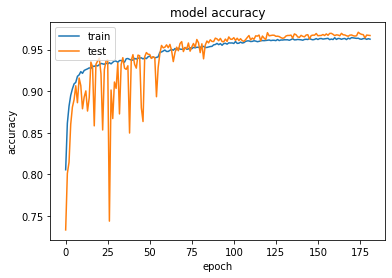

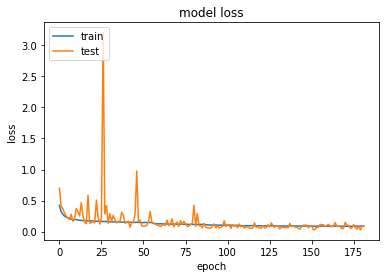

In [6]:
choice = 'tr'

np.random.seed(1) #fix randomness
if choice == 'cv':
  cross_validate(model, 10, X, Y)

elif choice == 'tr':
  model.initialize()
  model.train(Y, X) 

else:
  model.initialize()
  model.load("saves/final/convnet4.h5")

## Model Saving

In [7]:
weights_file = "saves/final/convnet4+batchnorm.h5"

nb_save_model(model, weights_file) 

[Target file: saves/final/convnet4+nolastrelu.h5]
Saving model to disk...done.


In [8]:
test_masks_dir = "test/pred/"
test_dir = "test/images/"

from recomposer import *
model = Recomposer(model)
model_rnv = Recomposer(model_rnv)
 
nb_predict_masks(model_rnv, test_dir, test_masks_dir)

Predicting test cases... 
Progress: done.


In [9]:
image_paths = [test_masks_dir + file for file in os.listdir(test_masks_dir)]

masks_to_submission("test/convnet4+batchnorm.csv", image_paths)

In [20]:
Y_pred = model.classify(X_test[0:10])
Y_pred_rnv = model_rnv.classify(X_test[0:10])

view_image_array(X_test[0:10], Y_pred, Y_pred_rnv)

Output hidden; open in https://colab.research.google.com to view.